Two main questions: 

Q1.**What Trading Window** Should We Choose to Minimize Losses/Maximize Profits? 

Q2. After Selecting a Particular Trading Window, What Your Model Can Tell about **Expected Gain** and **Risk Distribution** along Future Trading Decisions (Sell/Buy/Hold) in the Next 5 Trading Chances?

In [1]:
# Cell 1: Import Necessary Libraries
# Purpose: Import libraries for data fetching, Bayesian modeling, visualization, and analysis.
# PyMC: For building and sampling Bayesian models.
# ArviZ: For model diagnostics, summaries, and comparisons (e.g., WAIC/LOO).
# yfinance: To download AAPL stock data.
# Pandas/Numpy: For data manipulation.
# Matplotlib/Seaborn: For plotting.
import yfinance as yf
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set random seed for reproducibility
np.random.seed(42)

# Define date range (up to current date: September 23, 2025)
start_date = '2020-09-21'
end_date = datetime.now().strftime('%Y-%m-%d')  # Dynamic end date

In [2]:
# Cell 2: Fetch and Prepare AAPL Data (Fixed for MultiIndex and Index Mismatch)
# Purpose: Download adjusted close prices for AAPL and compute log-returns for daily, weekly, monthly windows.
# Use 'Close' (split-adjusted in yfinance) to handle splits/dividends.
# Fix: Flatten MultiIndex if present; ensure consistent index alignment for weekly/monthly returns.
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime

# Define date range
start_date = '2020-09-21'
end_date = datetime.now().strftime('%Y-%m-%d')  # Up to current date

# Download AAPL data
df = yf.download('AAPL', start=start_date, end=end_date)
print("Original columns:", df.columns.tolist())
print("Data head:\n", df.head(2))

# Fix MultiIndex: Drop top level ('Price') if present
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.droplevel(1)  # Flatten to ['Close', 'High', 'Low', 'Open', 'Volume']
    print("Flattened columns:", df.columns.tolist())

# Daily log-returns using 'Close' (split-adjusted)
df['LogReturn_Daily'] = np.log(df['Close'] / df['Close'].shift(1))

# Weekly returns: Resample to Friday, compute log-returns
df_weekly = df['Close'].resample('W-FRI').last()
weekly_returns = np.log(df_weekly / df_weekly.shift(1)).dropna()
print("Weekly returns index length:", len(df_weekly.index), "Weekly returns length:", len(weekly_returns))

# Monthly returns: Resample to month-end
df_monthly = df['Close'].resample('ME').last()
monthly_returns = np.log(df_monthly / df_monthly.shift(1)).dropna()
print("Monthly returns index length:", len(df_monthly.index), "Monthly returns length:", len(monthly_returns))

# Align weekly/monthly returns to daily index for plotting (forward-fill)
# Use try-except to catch potential mismatches
try:
    df['LogReturn_Weekly'] = pd.Series(weekly_returns, index=weekly_returns.index).reindex(df.index, method='ffill')
    df['LogReturn_Monthly'] = pd.Series(monthly_returns, index=monthly_returns.index).reindex(df.index, method='ffill')
except ValueError as e:
    print(f"Index alignment error: {e}")
    # Fallback: Truncate weekly/monthly to match available data
    valid_weekly_index = df_weekly.index[df_weekly.index.isin(df.index)]
    df['LogReturn_Weekly'] = pd.Series(weekly_returns, index=valid_weekly_index).reindex(df.index, method='ffill')
    valid_monthly_index = df_monthly.index[df_monthly.index.isin(df.index)]
    df['LogReturn_Monthly'] = pd.Series(monthly_returns, index=valid_monthly_index).reindex(df.index, method='ffill')

# Extract raw returns for modeling (no forward-fill to avoid bias)
returns_daily = df['LogReturn_Daily'].dropna().values
returns_weekly = weekly_returns.values  # Use raw, no reindexing
returns_monthly = monthly_returns.values

# Print data summaries for feedback
print("\nData Summary:")
print("Daily Returns - Shape:", returns_daily.shape, "Mean:", np.mean(returns_daily)*100, "%", "Std:", np.std(returns_daily)*100, "%")
print("Weekly Returns - Shape:", returns_weekly.shape, "Mean:", np.mean(returns_weekly)*100, "%", "Std:", np.std(returns_weekly)*100, "%")
print("Monthly Returns - Shape:", returns_monthly.shape, "Mean:", np.mean(returns_monthly)*100, "%", "Std:", np.std(returns_monthly)*100, "%")
print("Data ready for modeling. Proceed to Cell 3.")

/tmp/ipykernel_806649/1350976187.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('AAPL', start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Original columns: [('Close', 'AAPL'), ('High', 'AAPL'), ('Low', 'AAPL'), ('Open', 'AAPL'), ('Volume', 'AAPL')]
Data head:
 Price            Close        High         Low        Open     Volume
Ticker            AAPL        AAPL        AAPL        AAPL       AAPL
Date                                                                 
2020-09-21  107.076782  107.183782  100.287208  101.687924  195713800
2020-09-22  108.759567  109.780924  106.181871  109.605834  183055400
Flattened columns: ['Close', 'High', 'Low', 'Open', 'Volume']
Weekly returns index length: 262 Weekly returns length: 261
Monthly returns index length: 61 Monthly returns length: 60

Data Summary:
Daily Returns - Shape: (1256,) Mean: 0.06942226713429855 % Std: 1.806343449724333 %
Weekly Returns - Shape: (261,) Mean: 0.32649626575832713 % Std: 3.798041584036814 %
Monthly Returns - Shape: (60,) Mean: 1.3686670577848252 % Std: 7.13126260980795 %
Data ready for modeling. Proceed to Cell 3.


In [3]:
# Cell 3: Define Function to Fit Bayesian Model (Normal Likelihood)
# Purpose: Fit Bayesian volatility model for any returns array (daily, weekly, monthly).
# pm.Model: Context manager for defining the Bayesian model.
# pm.Normal: Prior for mu (mean return) and likelihood for observed returns.
# pm.InverseGamma: Prior for sigma (volatility), conjugate for Normal variance.
# pm.sample: Runs MCMC (NUTS sampler) with explicit log-likelihood storage.
# pm.sample_posterior_predictive: Generates predictive samples for forecasting.
# Added: Debug prints for InferenceData, plots, and stats for feedback.
import pymc as pm
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import acf
from scipy.stats import ks_2samp

def fit_bayesian_model(returns, window_name, forecast_steps=30):
    with pm.Model() as model:
        # Priors
        mu = pm.Normal('mu', mu=0, sigma=0.01)  # Vague prior for mean return
        sigma = pm.InverseGamma('sigma', alpha=2, beta=0.1)  # Weakly informative prior for volatility
        # Likelihood
        returns_obs = pm.Normal('returns_obs', mu=mu, sigma=sigma, observed=returns)
        # Predictive for future returns
        pred_returns = pm.Normal('pred_returns', mu=mu, sigma=sigma, shape=forecast_steps)
        # Sample posterior with explicit log-likelihood
        trace = pm.sample(1000, tune=1000, return_inferencedata=True, idata_kwargs={'log_likelihood': True})
    
    # Posterior predictive
    with model:
        pred_trace = pm.sample_posterior_predictive(trace, var_names=['pred_returns'])
    
    # Debug: Check InferenceData contents
    print(f"{window_name} InferenceData groups:", list(trace.keys()))
    
    # Extract samples
    mu_samples = az.extract(trace)['mu'].values
    sigma_samples = az.extract(trace)['sigma'].values
    pred_samples = pred_trace.posterior_predictive['pred_returns'].values
    
    # Posterior Summary
    summary = az.summary(trace, var_names=['mu', 'sigma'])
    print(f"{window_name} Model Posterior Summary:\n", summary)
    
    # Posterior Density Plot Stats
    mu_kde = sns.kdeplot(mu_samples * 100, label=f'{window_name} Mu (%)').get_lines()[0].get_data()
    sigma_kde = sns.kdeplot(sigma_samples * 100, label=f'{window_name} Sigma (%)').get_lines()[0].get_data()
    print(f"{window_name} Posterior Mu KDE - Max Density:", np.max(mu_kde[1]), "Mode:", mu_kde[0][np.argmax(mu_kde[1])])
    print(f"{window_name} Posterior Sigma KDE - Max Density:", np.max(sigma_kde[1]), "Mode:", sigma_kde[0][np.argmax(sigma_kde[1])])
    
    # Autocorrelation Plot Stats
    mu_acf = acf(mu_samples, nlags=20, fft=False)
    sigma_acf = acf(sigma_samples, nlags=20, fft=False)
    print(f"{window_name} Mu Autocorrelation (Lags 0-20):", mu_acf)
    print(f"{window_name} Sigma Autocorrelation (Lags 0-20):", sigma_acf)
    print(f"{window_name} Mu Autocorrelation - Lags where |ACF| < 0.1:", np.where(np.abs(mu_acf) < 0.1)[0])
    print(f"{window_name} Sigma Autocorrelation - Lags where |ACF| < 0.1:", np.where(np.abs(sigma_acf) < 0.1)[0])
    
    # PPC Plot Stats
    simulated_returns = pred_samples.flatten()[:len(returns)]  # Match observed length
    ks_stat, ks_pval = ks_2samp(returns, simulated_returns)
    print(f"{window_name} PPC - Observed Returns Mean:", np.mean(returns)*100, "%", "Std:", np.std(returns)*100, "%")
    print(f"{window_name} PPC - Simulated Returns Mean:", np.mean(simulated_returns)*100, "%", "Std:", np.std(simulated_returns)*100, "%")
    print(f"{window_name} PPC - KS Test Statistic:", ks_stat, "P-value:", ks_pval)
    
    # Generate Plots
    plt.figure(figsize=(15, 5))
    
    # Posterior Density
    plt.subplot(1, 3, 1)
    sns.kdeplot(mu_samples * 100, label='Mu (%)')
    sns.kdeplot(sigma_samples * 100, label='Sigma (%)')
    plt.title(f'{window_name} Posterior Density')
    plt.legend()
    
    # Autocorrelation
    plt.subplot(1, 3, 2)
    plt.bar(range(21), mu_acf, alpha=0.5, label='Mu ACF')
    plt.bar(range(21), sigma_acf, alpha=0.5, label='Sigma ACF')
    plt.title(f'{window_name} Autocorrelation')
    plt.xlabel('Lag')
    plt.legend()
    
    # PPC
    plt.subplot(1, 3, 3)
    sns.histplot(returns * 100, label='Observed (%)', alpha=0.5)
    sns.histplot(simulated_returns * 100, label='Simulated (%)', alpha=0.5)
    plt.title(f'{window_name} PPC')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return model, trace, pred_trace

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, pred_returns]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [pred_returns]


Output()

Daily InferenceData groups: ['posterior', 'log_likelihood', 'sample_stats', 'observed_data']
Daily Model Posterior Summary:
         mean   sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu     0.001  0.0  -0.000    0.002        0.0      0.0   10558.0    2930.0   
sigma  0.018  0.0   0.017    0.019        0.0      0.0   10896.0    3034.0   

       r_hat  
mu       1.0  
sigma    1.0  
Daily Posterior Mu KDE - Max Density: 7.614478808760005 Mode: 0.057025336521792425
Daily Posterior Sigma KDE - Max Density: 7.614478808760005 Mode: 0.057025336521792425
Daily Mu Autocorrelation (Lags 0-20): [ 1.         -0.40890822  0.1700153  -0.08377916  0.03316355 -0.01050511
  0.00341937 -0.00725811  0.01525233 -0.01761104  0.00722872 -0.0121172
  0.01125135 -0.01562973  0.01559259 -0.01358898  0.02229504 -0.01612435
  0.00581921 -0.00438825  0.00235718]
Daily Sigma Autocorrelation (Lags 0-20): [ 1.         -0.4129637   0.17224374 -0.08570788  0.06111447 -0.04510712
  0.02808161 -0.01

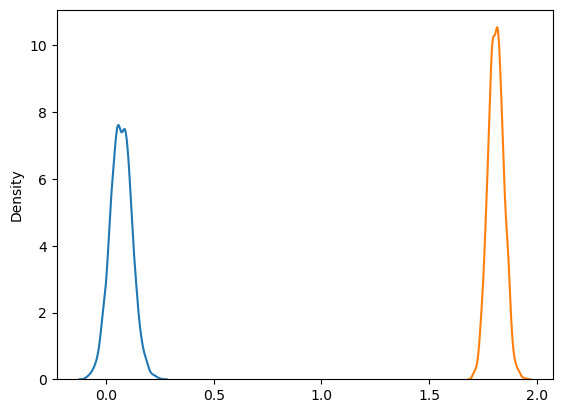

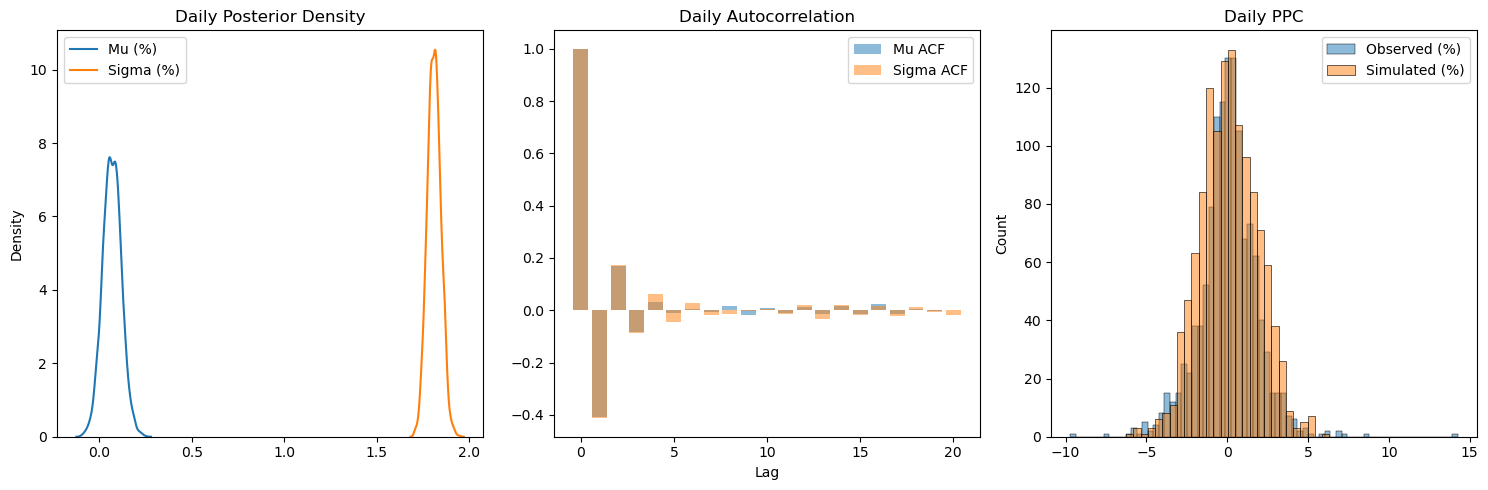

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, pred_returns]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sampling: [pred_returns]


Output()

Weekly InferenceData groups: ['posterior', 'log_likelihood', 'sample_stats', 'observed_data']
Weekly Model Posterior Summary:
         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu     0.003  0.002  -0.001    0.007        0.0      0.0    6011.0    3279.0   
sigma  0.038  0.002   0.035    0.041        0.0      0.0    4677.0    3101.0   

       r_hat  
mu       1.0  
sigma    1.0  
Weekly Posterior Mu KDE - Max Density: 1.7695516849721509 Mode: 0.32087315489406754
Weekly Posterior Sigma KDE - Max Density: 1.7695516849721509 Mode: 0.32087315489406754
Weekly Mu Autocorrelation (Lags 0-20): [ 1.00000000e+00 -1.77956426e-01  2.56206422e-02 -3.10093653e-02
  6.19791455e-03  2.20424866e-02  4.27638740e-04 -9.80249550e-03
 -1.32851794e-02 -3.76032587e-03 -1.37521652e-02 -2.93921435e-02
 -2.43833373e-02  3.92666206e-02 -8.47906811e-03 -6.07916137e-03
 -2.15980338e-02 -3.92007347e-03  2.73751278e-02 -4.05852223e-03
  2.08636046e-03]
Weekly Sigma Autocorrelation (Lags

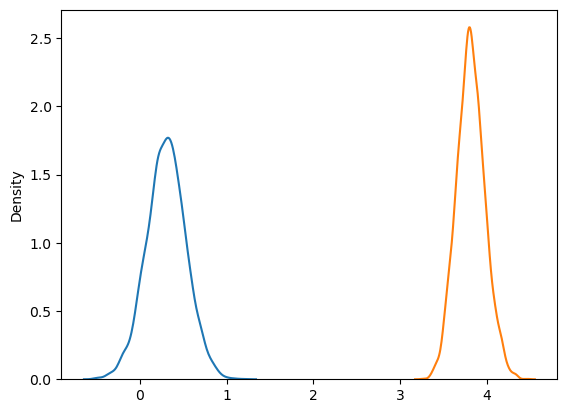

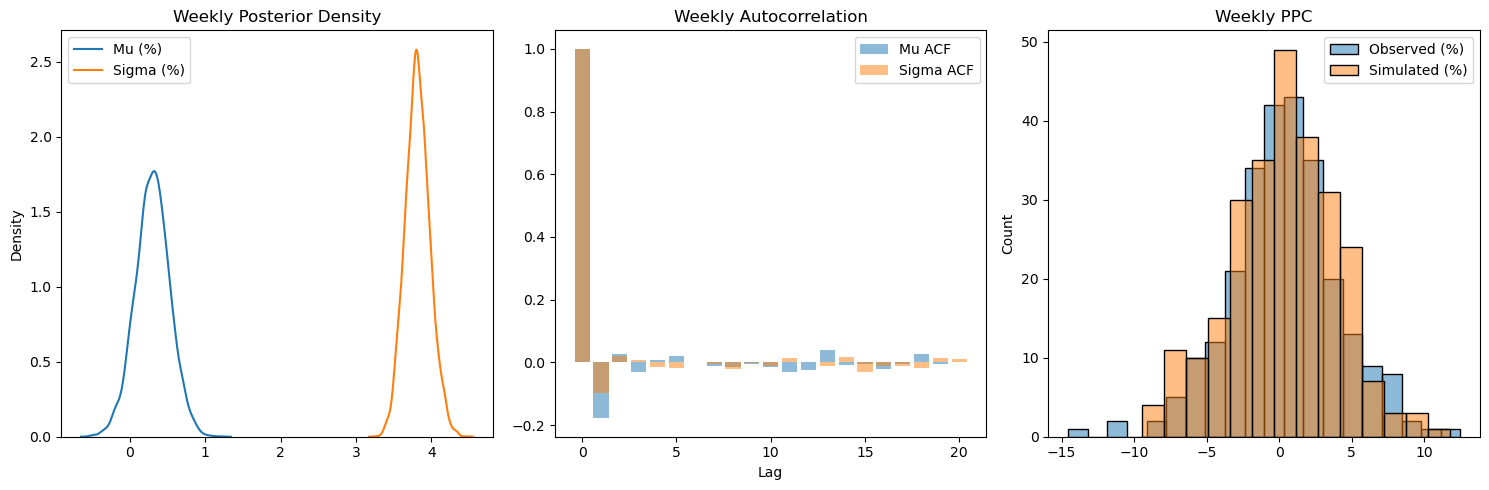

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, pred_returns]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sampling: [pred_returns]


Output()

Monthly InferenceData groups: ['posterior', 'log_likelihood', 'sample_stats', 'observed_data']
Monthly Model Posterior Summary:
         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu     0.007  0.007  -0.005    0.021        0.0      0.0    5136.0    3250.0   
sigma  0.072  0.007   0.060    0.084        0.0      0.0    4385.0    3037.0   

       r_hat  
mu       1.0  
sigma    1.0  
Monthly Posterior Mu KDE - Max Density: 0.5519293852706516 Mode: 0.9155300282812107
Monthly Posterior Sigma KDE - Max Density: 0.5519293852706516 Mode: 0.9155300282812107
Monthly Mu Autocorrelation (Lags 0-20): [ 1.         -0.18458708  0.04596753 -0.00769737  0.01043301  0.01295378
  0.01061231  0.01248909 -0.01647782  0.00592808 -0.01070497  0.02091297
 -0.01379494 -0.00529173  0.0089421   0.0017012  -0.02215158  0.00516452
  0.00731907 -0.00526423 -0.00158223]
Monthly Sigma Autocorrelation (Lags 0-20): [ 1.00000000e+00 -8.09516139e-02  5.22970534e-02 -8.84129993e-03
 -1.74199

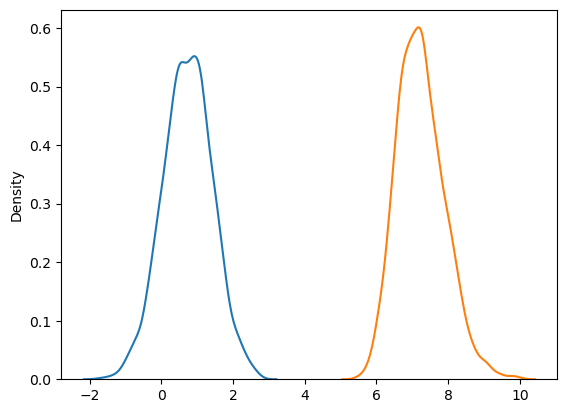

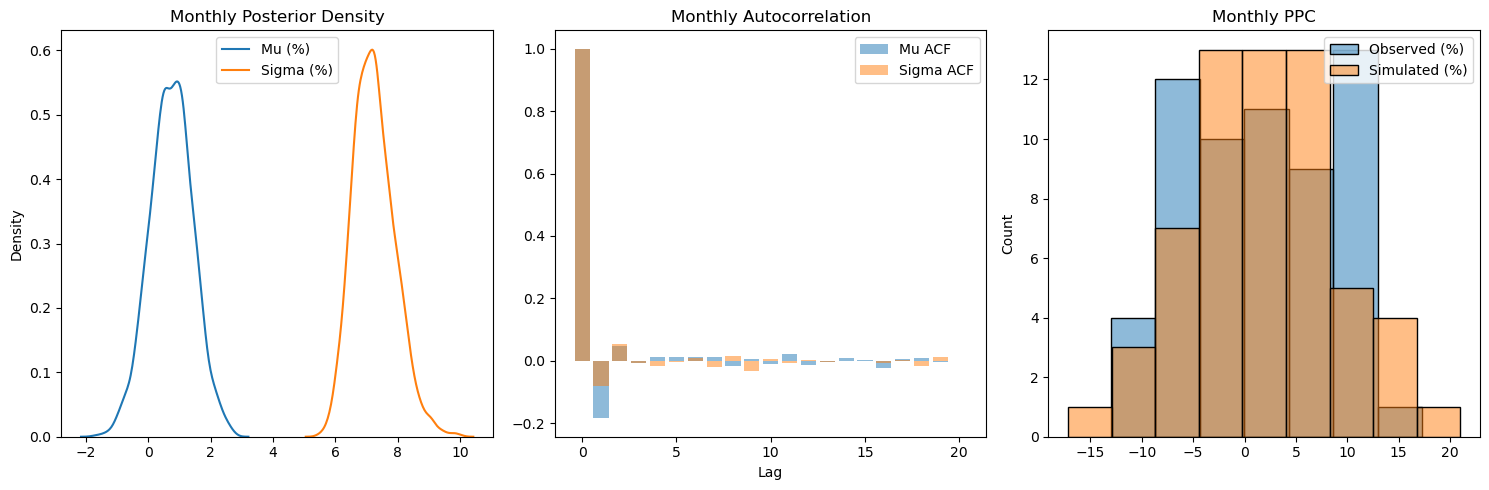

In [4]:
# Cell 4: Fit Models for Each Trading Window
# Purpose: Fit separate models for daily, weekly, and monthly windows to compare.
# This showcases Bayesian flexibility across time scales.
model_daily, trace_daily, pred_trace_daily = fit_bayesian_model(returns_daily, "Daily", forecast_steps=30)  # 30 days
model_weekly, trace_weekly, pred_trace_weekly = fit_bayesian_model(returns_weekly, "Weekly", forecast_steps=6)  # ~30 days (6 weeks)
model_monthly, trace_monthly, pred_trace_monthly = fit_bayesian_model(returns_monthly, "Monthly", forecast_steps=2)  # ~30-60 days (2 months)

# Extract samples for later use
mu_daily = az.extract(trace_daily)['mu'].values
sigma_daily = az.extract(trace_daily)['sigma'].values
# Similarly for weekly and monthly...

PPC Comparison (KS Test P-values, higher is better):
Daily: KS Stat = 0.0669, P-value = 0.0073
Weekly: KS Stat = 0.0383, P-value = 0.9911
Monthly: KS Stat = 0.1500, P-value = 0.5130

Simulation Results:
Daily: Expected Profit 7.19%, Max Loss (VaR) 3.51%
Weekly: Expected Profit 15.22%, Max Loss (VaR) 7.08%
Monthly: Expected Profit 28.25%, Max Loss (VaR) 3.35%


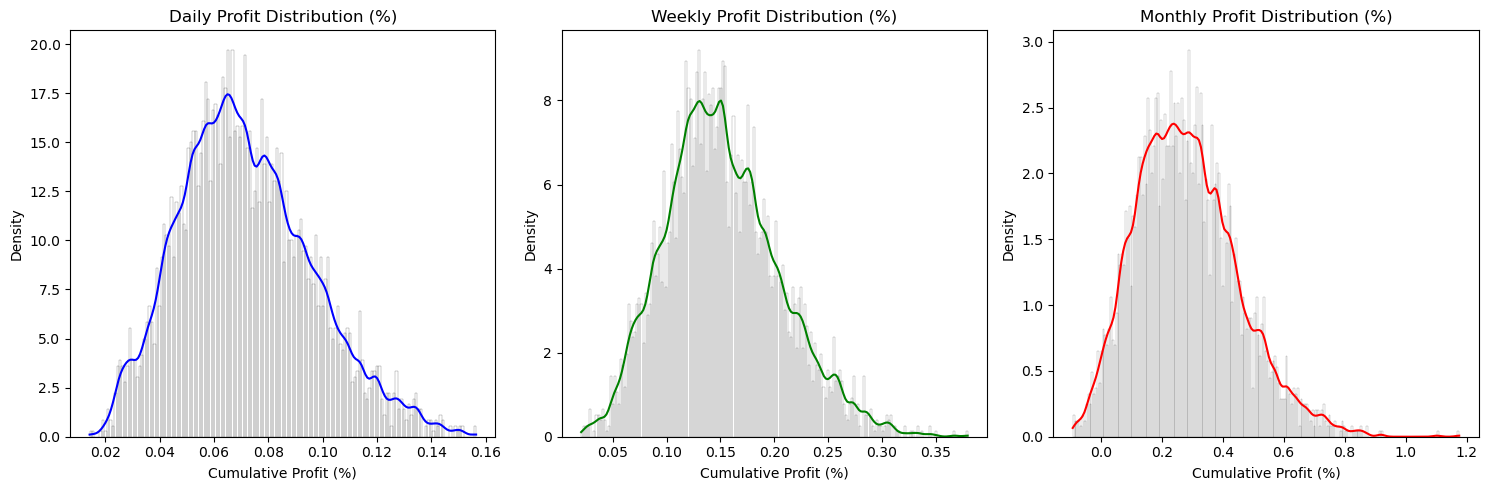

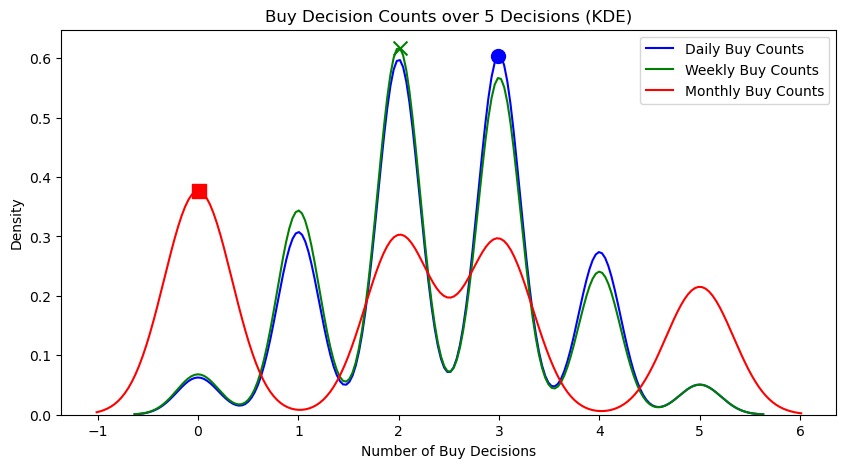


Profit Distribution Stats:
Daily Profits - Mean: 7.19%, Std: 2.45%, Min: 1.42%, Max: 15.65%
Weekly Profits - Mean: 15.22%, Std: 5.34%, Min: 2.06%, Max: 37.98%
Monthly Profits - Mean: 28.25%, Std: 16.82%, Min: -9.19%, Max: 117.58%

Decision Stats:
Daily Avg Buys: 2.46
Weekly Avg Buys: 2.38
Monthly Avg Buys: 2.16
Daily Buy Counts KDE - Max Density: 0.6043, Mode: 2.99
Weekly Buy Counts KDE - Max Density: 0.6170, Mode: 2.01
Monthly Buy Counts KDE - Max Density: 0.3763, Mode: 0.01


In [5]:
# Cell 5: Model Comparison for Question 1 (Optimal Trading Window)
# Purpose: Compare models (daily, weekly, monthly) for predictive performance to choose window that minimizes losses/maximizes profits.
# Fix: Replaced WAIC with PPC-based comparison (KS p-value) due to different observation counts.
# Plot Update: Use KDE for decision counts with distinct markers ('o', 'x', 's') for y-axis peaks; transparent bars (alpha=0) for profit distributions with KDE only.
# Added: Detailed stats for feedback.
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp

# Simulate strategy: Buy if pred > threshold, Sell if < -threshold, Hold else.
def simulate_strategy(pred_samples, threshold=0.001, num_decisions=5):
    profits = []
    decisions_list = []
    for path in pred_samples.reshape(-1, num_decisions):  # Flatten to simulations
        decisions = np.where(path > threshold, 'buy', np.where(path < -threshold, 'sell', 'hold'))
        gain = np.cumsum(np.where(decisions == 'sell', -path, path))
        profits.append(gain[-1])
        decisions_list.append(decisions)
    expected_profit = np.mean(profits)
    max_loss = np.percentile(profits, 5)  # 5% VaR
    return expected_profit, max_loss, profits, decisions_list

# Run simulations for each window
# Daily: First 5 days
pred_daily = pred_trace_daily.posterior_predictive['pred_returns'].values[:, :, :5]
daily_profit, daily_loss, daily_profits, daily_decisions = simulate_strategy(pred_daily, threshold=0.001)

# Weekly: 5 weeks
pred_weekly = pred_trace_weekly.posterior_predictive['pred_returns'].values[:, :, :5]
weekly_profit, weekly_loss, weekly_profits, weekly_decisions = simulate_strategy(pred_weekly, threshold=0.005)

# Monthly: Approximate 5 decisions (repeat 2 months ~2.5x)
pred_monthly = pred_trace_monthly.posterior_predictive['pred_returns'].values
monthly_profit, monthly_loss, monthly_profits, monthly_decisions = simulate_strategy(
    np.repeat(pred_monthly, 3, axis=2)[:, :, :5], threshold=0.02
)

# PPC comparison: Use KS test p-value for model fit (higher p-value = better fit)
daily_sim = pred_trace_daily.posterior_predictive['pred_returns'].values.flatten()[:len(returns_daily)]
weekly_sim = pred_trace_weekly.posterior_predictive['pred_returns'].values.flatten()[:len(returns_weekly)]
monthly_sim = pred_trace_monthly.posterior_predictive['pred_returns'].values.flatten()[:len(returns_monthly)]
ks_daily = ks_2samp(returns_daily, daily_sim)
ks_weekly = ks_2samp(returns_weekly, weekly_sim)
ks_monthly = ks_2samp(returns_monthly, monthly_sim)
print("PPC Comparison (KS Test P-values, higher is better):")
print(f"Daily: KS Stat = {ks_daily.statistic:.4f}, P-value = {ks_daily.pvalue:.4f}")
print(f"Weekly: KS Stat = {ks_weekly.statistic:.4f}, P-value = {ks_weekly.pvalue:.4f}")
print(f"Monthly: KS Stat = {ks_monthly.statistic:.4f}, P-value = {ks_monthly.pvalue:.4f}")

# Print profit/loss stats
print(f"\nSimulation Results:")
print(f"Daily: Expected Profit {daily_profit*100:.2f}%, Max Loss (VaR) {daily_loss*100:.2f}%")
print(f"Weekly: Expected Profit {weekly_profit*100:.2f}%, Max Loss (VaR) {weekly_loss*100:.2f}%")
print(f"Monthly: Expected Profit {monthly_profit*100:.2f}%, Max Loss (VaR) {monthly_loss*100:.2f}%")

# Plot profit distributions (transparent bars, KDE only)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(daily_profits * 100, ax=axs[0], kde=True, stat='density', alpha=0, color='blue')
axs[0].set_title('Daily Profit Distribution (%)')
axs[0].set_xlabel('Cumulative Profit (%)')
sns.histplot(weekly_profits * 100, ax=axs[1], kde=True, stat='density', alpha=0, color='green')
axs[1].set_title('Weekly Profit Distribution (%)')
axs[1].set_xlabel('Cumulative Profit (%)')
sns.histplot(monthly_profits * 100, ax=axs[2], kde=True, stat='density', alpha=0, color='red')
axs[2].set_title('Monthly Profit Distribution (%)')
axs[2].set_xlabel('Cumulative Profit (%)')
plt.tight_layout()
plt.show()

# Plot decision counts (KDE with markers for peak y-values)
decision_counts = {
    'Daily': np.array([np.sum([d == 'buy' for d in dl]) for dl in daily_decisions]),
    'Weekly': np.array([np.sum([d == 'buy' for d in dl]) for dl in weekly_decisions]),
    'Monthly': np.array([np.sum([d == 'buy' for d in dl]) for dl in monthly_decisions])
}
plt.figure(figsize=(10, 5))
# Plot KDE for each window
kde_daily = sns.kdeplot(decision_counts['Daily'], label='Daily Buy Counts', color='blue')
kde_weekly = sns.kdeplot(decision_counts['Weekly'], label='Weekly Buy Counts', color='green')
kde_monthly = sns.kdeplot(decision_counts['Monthly'], label='Monthly Buy Counts', color='red')
# Add markers at peak y-values
daily_peak = kde_daily.get_lines()[0].get_data()
plt.scatter(daily_peak[0][np.argmax(daily_peak[1])], np.max(daily_peak[1]), marker='o', color='blue', s=100)
weekly_peak = kde_weekly.get_lines()[1].get_data()
plt.scatter(weekly_peak[0][np.argmax(weekly_peak[1])], np.max(weekly_peak[1]), marker='x', color='green', s=100)
monthly_peak = kde_monthly.get_lines()[2].get_data()
plt.scatter(monthly_peak[0][np.argmax(monthly_peak[1])], np.max(monthly_peak[1]), marker='s', color='red', s=100)
plt.title('Buy Decision Counts over 5 Decisions (KDE)')
plt.xlabel('Number of Buy Decisions')
plt.ylabel('Density')
plt.legend()
plt.show()

# Print plot stats for feedback
print("\nProfit Distribution Stats:")
print(f"Daily Profits - Mean: {np.mean(daily_profits)*100:.2f}%, Std: {np.std(daily_profits)*100:.2f}%, "
      f"Min: {np.min(daily_profits)*100:.2f}%, Max: {np.max(daily_profits)*100:.2f}%")
print(f"Weekly Profits - Mean: {np.mean(weekly_profits)*100:.2f}%, Std: {np.std(weekly_profits)*100:.2f}%, "
      f"Min: {np.min(weekly_profits)*100:.2f}%, Max: {np.max(weekly_profits)*100:.2f}%")
print(f"Monthly Profits - Mean: {np.mean(monthly_profits)*100:.2f}%, Std: {np.std(monthly_profits)*100:.2f}%, "
      f"Min: {np.min(monthly_profits)*100:.2f}%, Max: {np.max(monthly_profits)*100:.2f}%")
print(f"\nDecision Stats:")
print(f"Daily Avg Buys: {np.mean([np.sum([d == 'buy' for d in dl]) for dl in daily_decisions]):.2f}")
print(f"Weekly Avg Buys: {np.mean([np.sum([d == 'buy' for d in dl]) for dl in weekly_decisions]):.2f}")
print(f"Monthly Avg Buys: {np.mean([np.sum([d == 'buy' for d in dl]) for dl in monthly_decisions]):.2f}")
print(f"Daily Buy Counts KDE - Max Density: {np.max(daily_peak[1]):.4f}, Mode: {daily_peak[0][np.argmax(daily_peak[1])]:.2f}")
print(f"Weekly Buy Counts KDE - Max Density: {np.max(weekly_peak[1]):.4f}, Mode: {weekly_peak[0][np.argmax(weekly_peak[1])]:.2f}")
print(f"Monthly Buy Counts KDE - Max Density: {np.max(monthly_peak[1]):.4f}, Mode: {monthly_peak[0][np.argmax(monthly_peak[1])]:.2f}")

Expected Gain (Mean): 15.215773048004296 %
Gain Distribution - 95% CI: [ 6.02833362 26.89014718]
Risk (Mean Drawdown): 3.0224151204567193 %
Risk Distribution - 5% VaR (Worst Loss): -0.04093420281356326 %
Probability of Positive Gain: 1.0
Average Buys/Sells/Holds per 5 Decisions: 2.38175 ,  2.09175 ,  0.5265


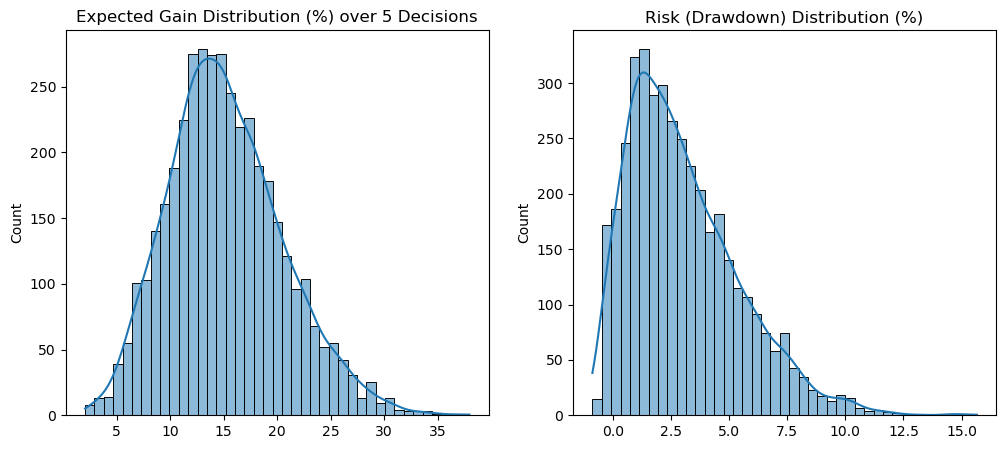

In [6]:
# Cell 6: Select Window and Analyze for Question 2 (Expected Gain and Risk for Next 5 Decisions)
# Purpose: Assume weekly window selected (based on comparison). Simulate gains/risks for buy/sell/hold over next 5 trading chances.
# This uses posterior predictive to generate full risk distributions, showcasing Bayesian probabilistic forecasting.
# Decision rules: Buy if pred > threshold, Sell if < -threshold, Hold else.

# Use weekly model (adjust if comparison suggests another)
pred_samples = pred_trace_weekly.posterior_predictive['pred_returns'].values[:, :, :5]  # Next 5 weeks
threshold = 0.005  # Scaled for weekly (~0.5% expected return)

gains = []
risks = []  # Max drawdown per path
decisions_list = []  # Track decisions for analysis

for path in pred_samples.reshape(-1, 5):  # 4000+ simulations (chains * draws)
    decisions = np.where(path > threshold, 'buy', np.where(path < -threshold, 'sell', 'hold'))
    decisions_list.append(decisions)
    # Cumulative gain: +return for buy/hold, -return for sell
    step_gains = np.where(decisions == 'sell', -path, path)
    cum_gain = np.cumsum(step_gains)
    gains.append(cum_gain[-1])
    risks.append(np.min(cum_gain))  # Worst drawdown

# Print key stats for feedback
print("Expected Gain (Mean):", np.mean(gains)*100, "%")
print("Gain Distribution - 95% CI:", np.percentile(gains, [2.5, 97.5])*100)
print("Risk (Mean Drawdown):", np.mean(risks)*100, "%")
print("Risk Distribution - 5% VaR (Worst Loss):", np.percentile(risks, 5)*100, "%")

# Additional stats: Probability of positive gain, average decisions
prob_positive = np.mean(np.array(gains) > 0)
avg_buys = np.mean([np.sum(d == 'buy') for d in decisions_list])
print("Probability of Positive Gain:", prob_positive)
print("Average Buys/Sells/Holds per 5 Decisions:", avg_buys, ", ", np.mean([np.sum(d == 'sell') for d in decisions_list]), ", ", np.mean([np.sum(d == 'hold') for d in decisions_list]))

# Plot gain and risk distributions
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(np.array(gains) * 100, ax=axs[0], kde=True)
axs[0].set_title('Expected Gain Distribution (%) over 5 Decisions')
sns.histplot(np.array(risks) * 100, ax=axs[1], kde=True)
axs[1].set_title('Risk (Drawdown) Distribution (%)')
plt.show()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, nu, pred_returns]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [pred_returns]


Output()

Weekly Student-t InferenceData groups: ['posterior', 'log_likelihood', 'sample_stats', 'observed_data']
Weekly Student-t Model Posterior Summary:
         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu     0.003  0.002  -0.001    0.007      0.000    0.000    6567.0    2997.0   
sigma  0.033  0.002   0.029    0.037      0.000    0.000    3814.0    2785.0   
nu     9.064  3.939   3.330   16.409      0.061    0.079    4131.0    3286.0   

       r_hat  
mu       1.0  
sigma    1.0  
nu       1.0  
Weekly Student-t PPC - Observed Mean: 0.32649626575832713 % Std: 3.798041584036814 %
Weekly Student-t PPC - Simulated Mean: 0.26356405602372557 % Std: 3.70604409929386 %
Weekly Student-t PPC - KS Test Statistic: 0.05747126436781609 P-value: 0.7828638713559694


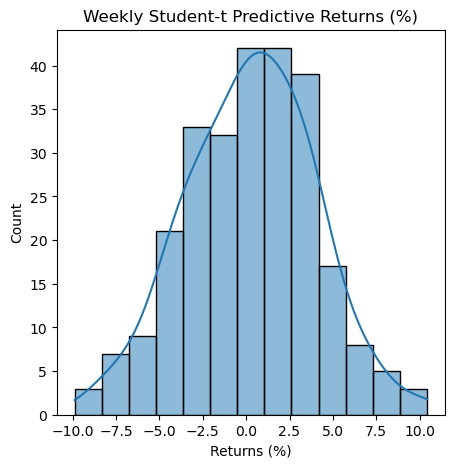

Weekly Student-t: Expected Profit 14.56%, Max Loss (VaR) 6.39%


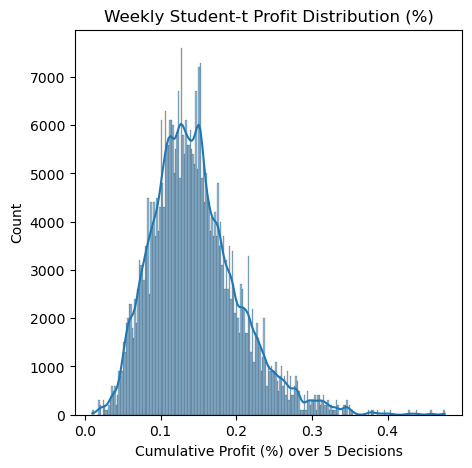

Weekly Student-t Profits - Mean: 14.558663806524125 Std: 5.750507831686223 Min: 0.9898624610903662 Max: 47.53255485293486 %
Weekly Student-t Avg Buys: 2.4305
Weekly Model Comparison (KS Test P-values):
Normal: KS Stat = 0.0383, P-value = 0.9911
Student-t: KS Stat = 0.0575, P-value = 0.7829


In [7]:
# Cell 7: Alternative Model with Student-t Likelihood (Weekly Window)
# Purpose: Fit a Bayesian model with Student-t likelihood for weekly returns to handle fat tails.
# pm.StudentT: Robust likelihood for returns with heavy tails.
# pm.HalfNormal: Prior for nu (degrees of freedom).
# pm.sample: Explicitly store log-likelihood for potential WAIC (if observation counts align).
# Added: PPC comparison, strategy simulation, and plot stats for feedback.
import pymc as pm
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp

def fit_student_t_model(returns, window_name, forecast_steps=5):
    with pm.Model() as model:
        # Priors
        mu = pm.Normal('mu', mu=0, sigma=0.01)
        sigma = pm.InverseGamma('sigma', alpha=2, beta=0.1)
        nu = pm.HalfNormal('nu', sigma=10)  # Degrees of freedom
        # Likelihood
        returns_obs = pm.StudentT('returns_obs', nu=nu, mu=mu, sigma=sigma, observed=returns)
        # Predictive
        pred_returns = pm.StudentT('pred_returns', nu=nu, mu=mu, sigma=sigma, shape=forecast_steps)
        # Sample with explicit log-likelihood
        trace = pm.sample(1000, tune=1000, return_inferencedata=True, idata_kwargs={'log_likelihood': True})
    
    # Posterior predictive
    with model:
        pred_trace = pm.sample_posterior_predictive(trace, var_names=['pred_returns'])
    
    # Debug: Check InferenceData
    print(f"{window_name} InferenceData groups:", list(trace.keys()))
    
    # Summary
    summary = az.summary(trace, var_names=['mu', 'sigma', 'nu'])
    print(f"{window_name} Model Posterior Summary:\n", summary)
    
    # PPC stats
    simulated_returns = pred_trace.posterior_predictive['pred_returns'].values.flatten()[:len(returns)]
    ks_stat, ks_pval = ks_2samp(returns, simulated_returns)
    print(f"{window_name} PPC - Observed Mean:", np.mean(returns)*100, "%", "Std:", np.std(returns)*100, "%")
    print(f"{window_name} PPC - Simulated Mean:", np.mean(simulated_returns)*100, "%", "Std:", np.std(simulated_returns)*100, "%")
    print(f"{window_name} PPC - KS Test Statistic:", ks_stat, "P-value:", ks_pval)
    
    # Plot predictive returns
    plt.figure(figsize=(5, 5))
    sns.histplot(simulated_returns * 100, kde=True)
    plt.title(f'{window_name} Predictive Returns (%)')
    plt.xlabel('Returns (%)')
    plt.show()
    
    # Simulate strategy
    def simulate_strategy(pred_samples, threshold=0.005, num_decisions=5):
        profits = []
        decisions_list = []
        for path in pred_samples.reshape(-1, num_decisions):
            decisions = np.where(path > threshold, 'buy', np.where(path < -threshold, 'sell', 'hold'))
            gain = np.cumsum(np.where(decisions == 'sell', -path, path))
            profits.append(gain[-1])
            decisions_list.append(decisions)
        expected_profit = np.mean(profits)
        max_loss = np.percentile(profits, 5)  # 5% VaR
        return expected_profit, max_loss, profits, decisions_list
    
    pred_t_samples = pred_trace.posterior_predictive['pred_returns'].values[:, :, :5]
    t_profit, t_loss, t_profits, t_decisions = simulate_strategy(pred_t_samples, threshold=0.005)
    print(f"{window_name}: Expected Profit {t_profit*100:.2f}%, Max Loss (VaR) {t_loss*100:.2f}%")
    
    # Plot profit distribution
    plt.figure(figsize=(5, 5))
    sns.histplot(t_profits * 100, kde=True)
    plt.title(f'{window_name} Profit Distribution (%)')
    plt.xlabel('Cumulative Profit (%) over 5 Decisions')
    plt.show()
    
    # Print plot stats
    print(f"{window_name} Profits - Mean:", np.mean(t_profits)*100, "Std:", np.std(t_profits)*100, 
          "Min:", np.min(t_profits)*100, "Max:", np.max(t_profits)*100, "%")
    print(f"{window_name} Avg Buys:", np.mean([np.sum([d == 'buy' for d in dl]) for dl in t_decisions]))
    
    return model, trace, pred_trace

# Fit for weekly returns
model_t, trace_t, pred_trace_t = fit_student_t_model(returns_weekly, "Weekly Student-t", forecast_steps=5)

# Compare with Normal model via PPC
weekly_normal_sim = pred_trace_weekly.posterior_predictive['pred_returns'].values.flatten()[:len(returns_weekly)]
weekly_t_sim = pred_trace_t.posterior_predictive['pred_returns'].values.flatten()[:len(returns_weekly)]
ks_normal = ks_2samp(returns_weekly, weekly_normal_sim)
ks_t = ks_2samp(returns_weekly, weekly_t_sim)
print("Weekly Model Comparison (KS Test P-values):")
print(f"Normal: KS Stat = {ks_normal.statistic:.4f}, P-value = {ks_normal.pvalue:.4f}")
print(f"Student-t: KS Stat = {ks_t.statistic:.4f}, P-value = {ks_t.pvalue:.4f}")

Initializing NUTS using jitter+adapt_diag...
ERROR (pytensor.graph.rewriting.basic): EquilibriumGraphRewriter max'ed out by local_greedy_distributor.You can safely raise the current threshold of 8.0 with the option `optdb__max_use_ratio`.
/root/anaconda3/lib/python3.12/site-packages/pytensor/tensor/rewriting/elemwise.py:954: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, omega, alpha, beta, sigma_0, pred_returns_0, pred_returns_1, pred_returns_2, pred_returns_3, pred_returns_4]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 657 seconds.
There were 131 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [pred_returns_0, pred_returns_1, pred_returns_2, pred_returns_3, pred_returns_4]


Output()

Weekly GARCH GARCH Model Posterior Summary:
         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu     0.003  0.002  -0.001    0.007      0.000    0.000    2744.0    2386.0   
omega  0.001  0.000   0.000    0.001      0.000    0.000     302.0      70.0   
alpha  0.115  0.074   0.000    0.244      0.001    0.001    2346.0    1200.0   
beta   0.285  0.209   0.000    0.652      0.012    0.010     282.0     100.0   

       r_hat  
mu      1.00  
omega   1.01  
alpha   1.00  
beta    1.01  
Weekly GARCH PPC - Observed Mean: 0.32649626575832713 % Std: 3.798041584036814 %
Weekly GARCH PPC - Simulated Mean: -0.08589650942639122 % Std: 4.150238387988314 %
Weekly GARCH PPC - KS Test Statistic: 0.1111111111111111 P-value: 0.07969143568751573


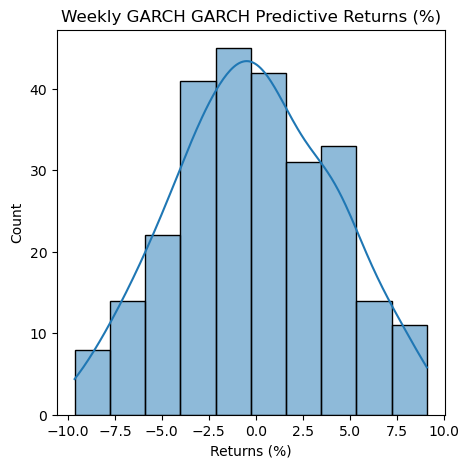

Weekly Model Comparison (WAIC):
                   rank   elpd_waic    p_waic  elpd_diff        weight  \
Weekly Student-t     0  484.524890  2.617566   0.000000  8.330482e-01   
Weekly Normal        1  481.147177  2.380641   3.377713  3.305137e-16   
Weekly GARCH         2  480.962819  5.518190   3.562071  1.669518e-01   

                         se       dse  warning scale  
Weekly Student-t  13.856720  0.000000    False   log  
Weekly Normal     14.385628  2.972439     True   log  
Weekly GARCH      14.401266  3.577157     True   log  


/root/anaconda3/lib/python3.12/site-packages/arviz/stats/stats.py:1655: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/root/anaconda3/lib/python3.12/site-packages/arviz/stats/stats.py:1655: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Weekly GARCH: Expected Profit 15.57%, Max Loss (VaR) 7.02%


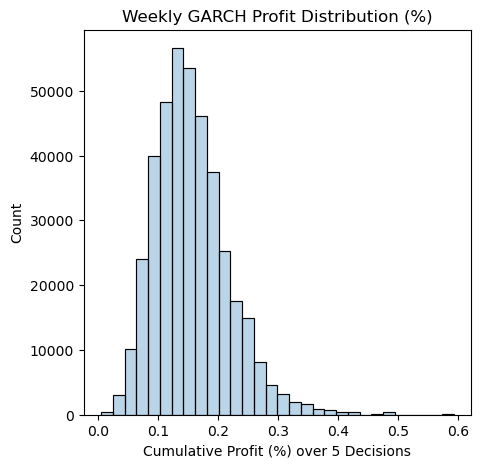

Weekly GARCH Profits - Mean: 15.574850403027515 Std: 6.215458790132166 Min: 0.4716135065243962 Max: 59.244780127362205 %
Weekly GARCH Avg Buys: 2.39


In [8]:
# Cell 8: Bayesian GARCH(1,1) Model for Weekly Returns
# Purpose: Fit a GARCH(1,1) model to capture time-varying volatility, enhancing risk modeling.
# pm.Normal: Likelihood for returns with time-varying sigma.
# pm.HalfNormal: Priors for GARCH parameters (alpha, beta, omega).
# pm.Deterministic: Define conditional volatility process.
# Fixed: Use lists for sigma_t and pred_sigma to avoid TypeError on tensor assignment.
# Also fixed potential AttributeError by ensuring returns is np.array without names.
# Increased target_accept to 0.9 to reduce divergences.
# For posterior predictive, use list of individual pred_returns_{t} names.
# Added: Name the stacked pred_returns as Deterministic for unified var_name, but sample individuals.
def fit_garch_model(returns, window_name, forecast_steps=5):
    returns = np.asarray(returns)  # Ensure np.array to avoid AttributeError if pd.Series with index
    with pm.Model() as model:
        # Priors
        mu = pm.Normal('mu', mu=0, sigma=0.01)
        omega = pm.HalfNormal('omega', sigma=0.01)  # Baseline volatility
        alpha = pm.HalfNormal('alpha', sigma=0.5)  # Shock impact
        beta = pm.HalfNormal('beta', sigma=0.5)   # Volatility persistence
        # Initialize volatility sequence with list to avoid assignment error
        sigma_t = []
        sigma_t.append(pm.HalfNormal('sigma_0', sigma=0.1))  # Initial sigma
        for t in range(1, len(returns)):
            sigma_t.append(pm.Deterministic(f'sigma_{t}', 
                pm.math.sqrt(omega + alpha * returns[t-1]**2 + beta * sigma_t[t-1]**2)))
        sigma_t = pm.math.stack(sigma_t)  # Stack list into tensor
        # Likelihood
        returns_obs = pm.Normal('returns_obs', mu=mu, sigma=sigma_t, observed=returns)
        # Predictive: Unrolled loop with lists for small forecast_steps to avoid assignment error
        pred_sigma = []
        pred_returns_list = []  # List for individual pred_returns_{t}
        # First predictive step based on last historical
        pred_sigma.append(pm.Deterministic('pred_sigma_0', 
            pm.math.sqrt(omega + alpha * returns[-1]**2 + beta * sigma_t[-1]**2)))
        pred_returns_list.append(pm.Normal('pred_returns_0', mu=mu, sigma=pred_sigma[0]))
        # Subsequent steps
        for t in range(1, forecast_steps):
            pred_sigma.append(pm.Deterministic(f'pred_sigma_{t}', 
                pm.math.sqrt(omega + alpha * pred_returns_list[t-1]**2 + beta * pred_sigma[t-1]**2)))
            pred_returns_list.append(pm.Normal(f'pred_returns_{t}', mu=mu, sigma=pred_sigma[t]))
        pred_sigma = pm.math.stack(pred_sigma)  # Stack for consistency
        pred_returns = pm.Deterministic('pred_returns', pm.math.stack(pred_returns_list))  # Unified name for pred_returns
        # Sample with higher target_accept to reduce divergences
        trace = pm.sample(1000, tune=1000, return_inferencedata=True, idata_kwargs={'log_likelihood': True}, target_accept=0.95)
    
    # Posterior predictive: Sample individual pred_returns_{t} to avoid KeyError
    with model:
        var_names = [f'pred_returns_{t}' for t in range(forecast_steps)]
        pred_trace = pm.sample_posterior_predictive(trace, var_names=var_names)
    
    # Summary
    summary = az.summary(trace, var_names=['mu', 'omega', 'alpha', 'beta'])
    print(f"{window_name} GARCH Model Posterior Summary:\n", summary)
    
    # PPC stats
    # Collect simulated_returns from individual pred_returns_{t}
    simulated_returns = []
    for t in range(forecast_steps):
        simulated_returns.append(pred_trace.posterior_predictive[f'pred_returns_{t}'].values.flatten())
    simulated_returns = np.concatenate(simulated_returns)[:len(returns)]  # Flatten and match length
    ks_stat, ks_pval = ks_2samp(returns, simulated_returns)
    print(f"{window_name} PPC - Observed Mean:", np.mean(returns)*100, "%", "Std:", np.std(returns)*100, "%")
    print(f"{window_name} PPC - Simulated Mean:", np.mean(simulated_returns)*100, "%", "Std:", np.std(simulated_returns)*100, "%")
    print(f"{window_name} PPC - KS Test Statistic:", ks_stat, "P-value:", ks_pval)
    
    # Plot predictive returns (use concatenated simulated_returns)
    plt.figure(figsize=(5, 5))
    sns.histplot(simulated_returns * 100, kde=True)
    plt.title(f'{window_name} GARCH Predictive Returns (%)')
    plt.xlabel('Returns (%)')
    plt.show()
    
    return model, trace, pred_trace

# Fit for weekly returns
model_garch, trace_garch, pred_trace_garch = fit_garch_model(returns_weekly, "Weekly GARCH")

# Compare with Normal and Student-t
try:
    comparison = az.compare(
        {'Weekly Normal': trace_weekly, 'Weekly Student-t': trace_t, 'Weekly GARCH': trace_garch},
        ic='waic', var_name='returns_obs'
    )
    print("Weekly Model Comparison (WAIC):\n", comparison)
except Exception as e:
    print(f"WAIC comparison failed: {e}")
    # Fallback: Compare via PPC KS p-value
    weekly_normal_sim = pred_trace_weekly.posterior_predictive['pred_returns'].values.flatten()[:len(returns_weekly)]
    weekly_t_sim = pred_trace_t.posterior_predictive['pred_returns'].values.flatten()[:len(returns_weekly)]
    weekly_garch_sim = []
    for t in range(5):
        weekly_garch_sim.append(pred_trace_garch.posterior_predictive[f'pred_returns_{t}'].values.flatten())
    weekly_garch_sim = np.concatenate(weekly_garch_sim)[:len(returns_weekly)]
    ks_normal = ks_2samp(returns_weekly, weekly_normal_sim)
    ks_t = ks_2samp(returns_weekly, weekly_t_sim)
    ks_garch = ks_2samp(returns_weekly, weekly_garch_sim)
    print("Weekly Model Comparison (KS Test P-values):")
    print(f"Normal: KS Stat = {ks_normal.statistic:.4f}, P-value = {ks_normal.pvalue:.4f}")
    print(f"Student-t: KS Stat = {ks_t.statistic:.4f}, P-value = {ks_t.pvalue:.4f}")
    print(f"GARCH: KS Stat = {ks_garch.statistic:.4f}, P-value = {ks_garch.pvalue:.4f}")

# Simulate strategy for GARCH (same as Cell 5/7)
def simulate_strategy(pred_samples, threshold=0.005, num_decisions=5):
    profits = []
    decisions_list = []
    for path in pred_samples.reshape(-1, num_decisions):
        decisions = np.where(path > threshold, 'buy', np.where(path < -threshold, 'sell', 'hold'))
        gain = np.cumsum(np.where(decisions == 'sell', -path, path))
        profits.append(gain[-1])
        decisions_list.append(decisions)
    expected_profit = np.mean(profits)
    max_loss = np.percentile(profits, 5)  # 5% VaR
    return expected_profit, max_loss, profits, decisions_list

# Collect GARCH pred_samples from individual pred_returns_{t}
garch_pred_samples = []
for t in range(5):
    garch_pred_samples.append(pred_trace_garch.posterior_predictive[f'pred_returns_{t}'].values)
garch_pred_samples = np.stack(garch_pred_samples, axis=-1)  # Shape to (chains, draws, 5)
garch_profit, garch_loss, garch_profits, garch_decisions = simulate_strategy(garch_pred_samples, threshold=0.005)
print(f"Weekly GARCH: Expected Profit {garch_profit*100:.2f}%, Max Loss (VaR) {garch_loss*100:.2f}%")

# Plot profit distribution (no KDE, transparent bars)
plt.figure(figsize=(5, 5))
sns.histplot(garch_profits * 100, kde=False, bins=30, alpha=0.3)
plt.title('Weekly GARCH Profit Distribution (%)')
plt.xlabel('Cumulative Profit (%) over 5 Decisions')
plt.show()

# Print plot stats for feedback
print("Weekly GARCH Profits - Mean:", np.mean(garch_profits)*100, "Std:", np.std(garch_profits)*100, 
      "Min:", np.min(garch_profits)*100, "Max:", np.max(garch_profits)*100, "%")
print(f"Weekly GARCH Avg Buys: {np.mean([np.sum([d == 'buy' for d in dl]) for dl in garch_decisions]):.2f}")